# Setup

In [60]:
import time, os, glob

import torch
torch.manual_seed(0)
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm import tqdm
import copy
import csv

from training.model import *
from training.datasets import *
from inference.heatmap import *

In [61]:
DEBUG = False
TILE_DIR = 'tiles2/'
MODEL_DIR = 'checkpoints/PlaqueTissueClassifier_Epoch_0.pth'
SAVE_PLAQ_DIR = 'dummy_outputs/heatmaps/'
TISSUE_PRESENCE_FILE = 'tissue_presence.csv'
# BrainSec
SAVE_IMG_DIR = 'dummy_outputs/images/'
SAVE_NP_DIR = 'dummy_outputs/numpy/'

IMG_SIZE = 1536
STRIDE = 128
# NOTE: inference loop expects batch size that is <= img size / stride and 
# where img size / batch size is an integer
BATCH_SIZE = IMG_SIZE // STRIDE
NUM_WORKERS = 2

In [62]:
if not os.path.exists(SAVE_PLAQ_DIR):
    os.makedirs(SAVE_PLAQ_DIR)
    
if not os.path.exists(SAVE_IMG_DIR):
        os.makedirs(SAVE_IMG_DIR)
        
if not os.path.exists(SAVE_NP_DIR):
        os.makedirs(SAVE_NP_DIR)

In [63]:
# Retrieve Files
filenames = glob.glob(TILE_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
filenames = sorted(filenames)
print(filenames)

['Q', 'QQ', 'QQQ', 'RR', 'RRR', 'S', 'SS', 'SSS', 'T', 'TT', 'TTT', 'U', 'UU', 'UUU']


# Inference Pipeline

In [64]:
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)
    

In [65]:
model = PlaqueTissueClassifier().to('cpu')
checkpoint = torch.load(MODEL_DIR, map_location=torch.device('cpu'))

new_state_dict = dict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace('module.', '') # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

/Users/oliviashen/anaconda3/envs/brainsec/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/2871139323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa

<All keys matched successfully>

In [66]:
print(sum(p.numel() for p in model.parameters()))

def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

get_model_size_mb(model)

930470
model size: 3.596MB


Only process the first 2 files to test.

In [67]:
filenames = filenames[0:1]

In [68]:
import time
# Inference Loop:

for slidename in filenames:
    print("Now processing: ", slidename)
    # Read tissue presence map into list
    with open(os.path.join(TILE_DIR, slidename, TISSUE_PRESENCE_FILE), newline='') as f:
        tissue_is_present = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

    row_nums = (len(tissue_is_present))
    col_nums = len(tissue_is_present[0])   
    
    # Initialize outputs accordingly:
    heatmap_res = IMG_SIZE // STRIDE
    plaque_output = np.zeros((3, heatmap_res*row_nums, heatmap_res*col_nums))
    seg_output = np.zeros((heatmap_res*row_nums, heatmap_res*col_nums), dtype=np.uint8)

    # set model to evaluation mode
    model.eval()
    start_time = time.perf_counter() # To evaluate Time taken per inference

    if DEBUG:
        row_range = [3, 4]
        col_range = [7, 8, 9]
    else:
        row_range = range(row_nums)
        col_range = range(col_nums)

    for row in row_range:
        for col in col_range:
            print(f"Tile ({row},{col})")
            # if tile has no tissue, skip
            if not tissue_is_present[row][col]:
                print("No tissue. Skipping.")
                continue
            print("Contains tissue.")
            # Load tile with padding into dataset
            image_datasets = HeatmapDataset(os.path.join(TILE_DIR, slidename, '0'), row, col, stride=STRIDE)
            dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE,
                                                 shuffle=False, num_workers=NUM_WORKERS)
            
            running_plaques = torch.Tensor(0)
            # create numpy array of heatmap
            output_class = np.zeros((heatmap_res, heatmap_res), dtype=np.uint8)
            
            for idx, data in enumerate(dataloader):
                # get plaque and tissue outputs
                p_out, t_out = model(data)
                # binarize output of plaque prediction and save
                p_preds = torch.nn.functional.sigmoid(p_out.data)
                running_plaques = torch.cat([running_plaques, p_preds])
                _, t_preds = torch.max(t_out.data, 1)
                i = (idx // (heatmap_res//BATCH_SIZE))
                j = (idx % (heatmap_res//BATCH_SIZE))
                output_class[i,j*BATCH_SIZE:(j+1)*BATCH_SIZE] = t_preds.data
        
            # Final Outputs of Brain Segmentation
            seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class
            
            # Final Outputs of Plaque Detection:
            cored = np.asarray(running_plaques[:,0]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
            diffuse = np.asarray(running_plaques[:,1]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
            caa = np.asarray(running_plaques[:,2]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
            
            plaque_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
            plaque_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
            plaque_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

            seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class

    # Saving Confidence=[0,1] for Plaque Detection
    np.save(os.path.join(SAVE_PLAQ_DIR, slidename), plaque_output)
    
    # Saving BrainSeg Classification={0,1,2}
    np.save(os.path.join(SAVE_NP_DIR, slidename), seg_output)
    saveBrainSegImage(seg_output, os.path.join(SAVE_IMG_DIR, slidename + '.png'))
    
    # Time Statistics for Inference
    end_time = time.perf_counter()
    print("Time to process " + slidename + ": ", end_time-start_time, "sec")

Now processing:  Q
Tile (0,0)
No tissue. Skipping.
Tile (0,1)
No tissue. Skipping.
Tile (0,2)
No tissue. Skipping.
Tile (0,3)
No tissue. Skipping.
Tile (0,4)
No tissue. Skipping.
Tile (0,5)
No tissue. Skipping.
Tile (0,6)
No tissue. Skipping.
Tile (0,7)
No tissue. Skipping.
Tile (0,8)
No tissue. Skipping.
Tile (0,9)
No tissue. Skipping.
Tile (0,10)
No tissue. Skipping.
Tile (0,11)
No tissue. Skipping.
Tile (0,12)
No tissue. Skipping.
Tile (0,13)
No tissue. Skipping.
Tile (0,14)
No tissue. Skipping.
Tile (0,15)
No tissue. Skipping.
Tile (0,16)
No tissue. Skipping.
Tile (0,17)
No tissue. Skipping.
Tile (0,18)
No tissue. Skipping.
Tile (0,19)
No tissue. Skipping.
Tile (0,20)
No tissue. Skipping.
Tile (0,21)
No tissue. Skipping.
Tile (0,22)
No tissue. Skipping.
Tile (0,23)
No tissue. Skipping.
Tile (0,24)
No tissue. Skipping.
Tile (0,25)
No tissue. Skipping.
Tile (0,26)
Contains tissue.


/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/8853984.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  output_class[i,j*BATCH_SIZE:(j+1)*BATCH_SIZE] = t_preds.data


Tile (0,27)
No tissue. Skipping.
Tile (0,28)
No tissue. Skipping.
Tile (0,29)
No tissue. Skipping.
Tile (0,30)
No tissue. Skipping.
Tile (0,31)
No tissue. Skipping.
Tile (1,0)
No tissue. Skipping.
Tile (1,1)
No tissue. Skipping.
Tile (1,2)
No tissue. Skipping.
Tile (1,3)
No tissue. Skipping.
Tile (1,4)
No tissue. Skipping.
Tile (1,5)
No tissue. Skipping.
Tile (1,6)
No tissue. Skipping.
Tile (1,7)
No tissue. Skipping.
Tile (1,8)
No tissue. Skipping.
Tile (1,9)
No tissue. Skipping.
Tile (1,10)
No tissue. Skipping.
Tile (1,11)
No tissue. Skipping.
Tile (1,12)
No tissue. Skipping.
Tile (1,13)
Contains tissue.
Tile (1,14)
Contains tissue.
Tile (1,15)
Contains tissue.
Tile (1,16)
Contains tissue.
Tile (1,17)
Contains tissue.
Tile (1,18)
No tissue. Skipping.
Tile (1,19)
No tissue. Skipping.
Tile (1,20)
No tissue. Skipping.
Tile (1,21)
No tissue. Skipping.
Tile (1,22)
No tissue. Skipping.
Tile (1,23)
No tissue. Skipping.
Tile (1,24)
No tissue. Skipping.
Tile (1,25)
No tissue. Skipping.
Tile (1

In [ ]:
def plot_heatmap(final_output) :
    """
    Plots Confidence Heatmap of Plaques = [0,1]
    
    Inputs:
        final_output (NumPy array of 
        3*img_height*height_width) :
            Contains Plaque Confidence with each axis
            representing different types of plaque
            
    Outputs:
        Subplots containing Plaque Confidences
    """
    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(221)
    ax.set_title('cored')

    im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(222)
    ax.set_title('diffuse')

    im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(223)
    ax.set_title('CAA')
    im = ax.imshow(final_output[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/1405840043.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/1405840043.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/1405840043.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.color

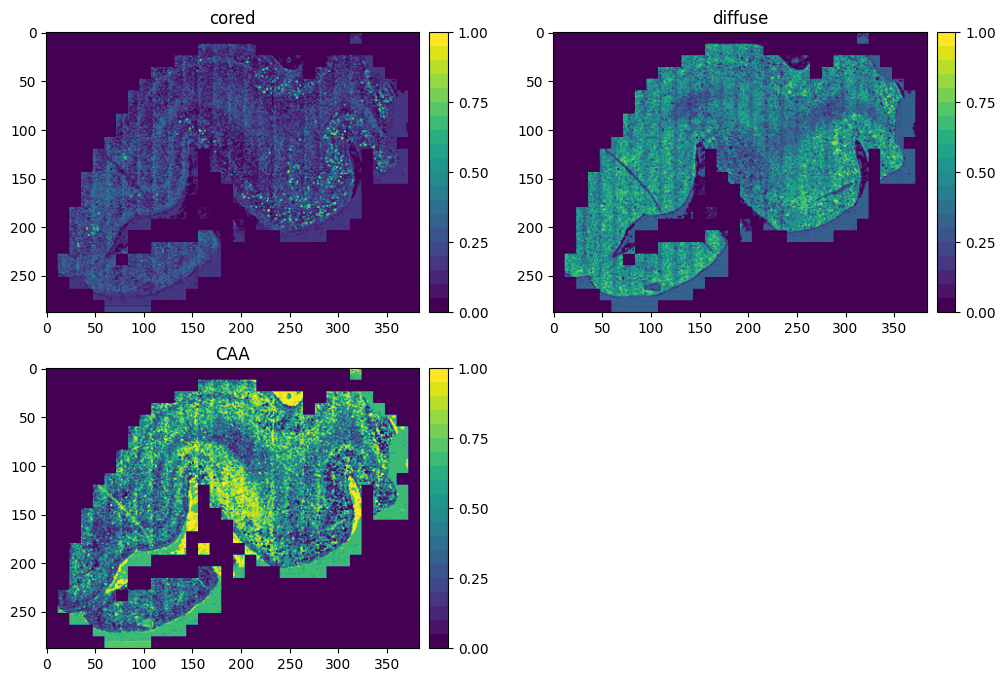

In [70]:
plot_heatmap(plaque_output)

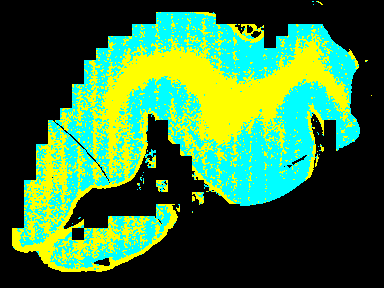

In [71]:
from IPython.display import display
tissue_seg_img = Image.open(os.path.join(SAVE_IMG_DIR, "Q.png"))
display(tissue_seg_img)

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/1405840043.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/1405840043.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_3451/1405840043.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.color

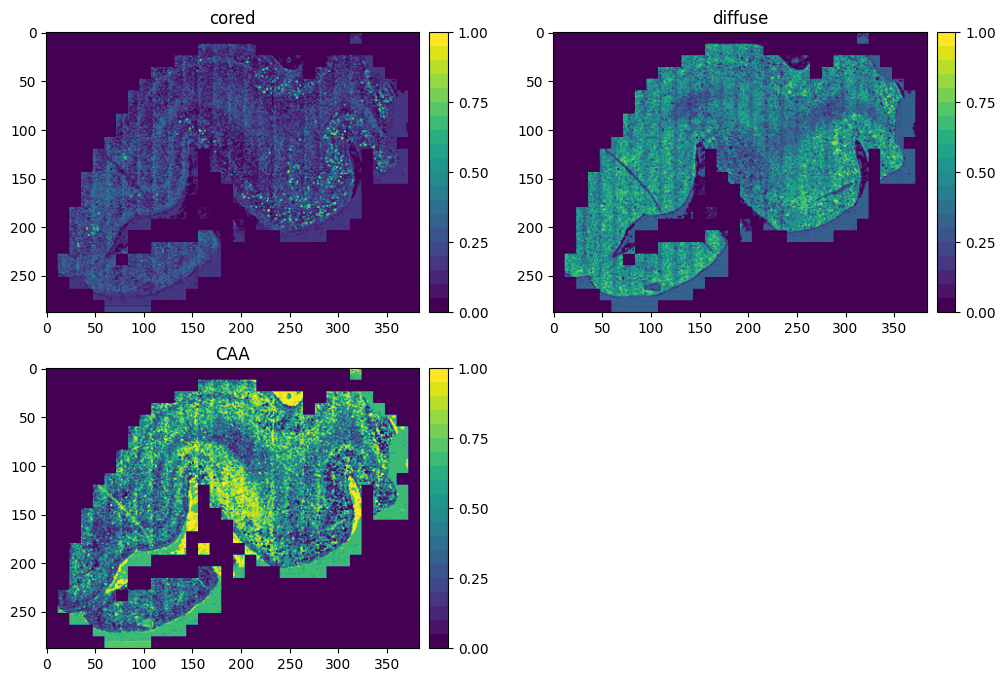

In [72]:
plaque_output = np.load(SAVE_PLAQ_DIR + 'Q.npy')
plot_heatmap(plaque_output)

In [73]:
from wsi.slide import *

slide_info('data/Q.svs')
slide_info('data/QQ.svs')


Opening Slide: data/Q.svs
Level count: 3
Level dimensions: ((47808, 35973), (11952, 8993), (2988, 2248))
Level downsamples: (1.0, 4.000055598799066, 16.00111209964413)
Dimensions: (47808, 35973)
Objective power: 20
Associated images:
  thumbnail: <PIL.Image.Image image mode=RGBA size=1020x768 at 0x15C35CD60>
Format: aperio
Time elapsed: 0:00:00.064287

Opening Slide: data/QQ.svs
Level count: 4
Level dimensions: ((91631, 74723), (22907, 18680), (5726, 4670), (2863, 2335))
Level downsamples: (1.0, 4.000145781952891, 16.001631014022966, 32.00326202804593)
Dimensions: (91631, 74723)
Objective power: 40
Associated images:
  thumbnail: <PIL.Image.Image image mode=RGBA size=941x768 at 0x15C35CD30>
Format: aperio
Time elapsed: 0:00:00.021903


# Post Processing

In [74]:
import csv
import glob, os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats

from tqdm import tqdm

In [75]:
from PIL import Image
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [76]:
from PIL import Image
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
# import lxml.etree as ET
from tqdm import tqdm

# Post-Processing BrainSeg - Jeff, Kolin, Wenda
def method_6(mask_img: "Image", down_factor=4):
    """Downsample => Area_opening (Remove local maxima) =>
    Swap index of GM and WM => Area_opening => Swap index back =>
    Area_closing => Morphological opening => Upsample"""
    # pylint: disable=invalid-name
    def swap_GM_WM(arr):
        """Swap GM and WM in arr (swaps index 1 and index 2)"""
        arr_1 = (arr == 1)
        arr[arr == 2] = 1
        arr[arr_1] = 2
        del arr_1
        return arr
    # pylint: enable=invalid-name

    mask_img = Image.fromarray(mask_img)
    width, height = mask_img.width, mask_img.height
    area_threshold_prop = 0.05
    area_threshold = int(area_threshold_prop * width * height // down_factor**2)

    # Downsample the image
    mask_arr = np.array(
        mask_img.resize((width // down_factor, height // down_factor), Image.NEAREST))
    del mask_img
    print('Finish downsampling')

    # Apply area_opening to remove local maxima with area < 20000 px
    mask_arr = morphology.area_opening(mask_arr, area_threshold=3200 // down_factor**2)
    print('Finish area_opening #1')

    # Swap index of GM and WM
    mask_arr = swap_GM_WM(mask_arr)
    print('Finish swapping index')

    # Apply area_opening to remove local maxima with area < 20000 px
    mask_arr = morphology.area_opening(mask_arr, area_threshold=3200 // down_factor**2)
    print('Finish area_opening #2')

    # Swap index back
    mask_arr = swap_GM_WM(mask_arr)
    print('Finish swapping index back')

    # Apply area_closing to remove local minima with area < 12500 px
    mask_arr = morphology.area_closing(mask_arr, area_threshold=2000 // down_factor**2)
    print('Finish area_closing')

    # Apply remove_small_objects to remove tissue residue with area < 0.05 * width * height
    tissue_arr = morphology.remove_small_objects(mask_arr > 0, min_size=area_threshold,
                                                 connectivity=2)
    mask_arr[np.invert(tissue_arr)] = 0
    del tissue_arr
    print('Finish remove_small_objects')

    # Apply opening with disk-shaped kernel (r=8) to smooth boundary
    mask_arr = morphology.opening(mask_arr, footprint=morphology.disk(radius=32 // down_factor))
    print('Finish morphological opening')

    # Upsample the output
    mask_arr = np.array(Image.fromarray(mask_arr).resize((width, height), Image.NEAREST))
    print('Finish upsampling')

    return mask_arr

In [77]:
# Plaque-counting Directories
SAVE_DIR = 'outputs/CNNscore/'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
CSV_DIR = 'outputs/CNNscore/WSI_CERAD_AREA.csv'
HEATMAP_DIR = 'outputs/heatmaps/'

# BrainSeg Post-processing Directories
BRAINSEG_NP_PRE_DIR = 'outputs/numpy/'
POST_IMG_DIR = 'postprocess/images/'
POST_NP_DIR = 'postprocess/numpy/'
if not os.path.exists(POST_IMG_DIR):
    os.makedirs(POST_IMG_DIR)
if not os.path.exists(POST_NP_DIR):
    os.makedirs(POST_NP_DIR)
# Counted Plaques Save Directories
SAVE_IMG_DIR = 'outputs/masked_plaque/images/'
if not os.path.exists(SAVE_IMG_DIR):
    os.makedirs(SAVE_IMG_DIR)
SAVE_NP_DIR = 'outputs/masked_plaque/numpy/'
if not os.path.exists(SAVE_NP_DIR):
    os.makedirs(SAVE_NP_DIR)



In [78]:
filenames = sorted(os.listdir(BRAINSEG_NP_PRE_DIR))
filenames = [os.path.splitext(file)[0] for file in filenames]
print(filenames)
print(len(filenames))

['Q', 'QQ']
2


In [79]:
# Post-process BrainSeg
for filename in tqdm(filenames) :
    fileLoc = BRAINSEG_NP_PRE_DIR + filename + ".npy"
    print("Loading: " + fileLoc)
    seg_pic = np.load(fileLoc)
    processed = method_6(seg_pic)
    np.save(POST_NP_DIR+filename, processed)
    saveBrainSegImage(processed, \
                      POST_IMG_DIR + filename + '.png')

100%|██████████| 2/2 [00:00<00:00, 21.04it/s]

Loading: outputs/numpy/Q.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling
Saved at: postprocess/images/Q.png
Loading: outputs/numpy/QQ.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling
Saved at: postprocess/images/QQ.png


In [80]:
# UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18,
# use 'connectivity' instead. For neighbors=8, use connectivity=2
#   This is separate from the ipykernel package so we can avoid doing imports until

# Post-Processing to count Plaques
def count_blobs(mask,
               threshold=1500):
#     labels = measure.label(mask, neighbors=8, background=0)
    labels = measure.label(mask, connectivity=2, background=0)
    img_mask = np.zeros(mask.shape, dtype='uint8')
    labeled_mask = np.zeros(mask.shape, dtype='uint16')
    sizes = []
    locations = []
    
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(mask.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > threshold:
            sizes.append(numPixels)
            img_mask = cv2.add(img_mask, labelMask)
            
            # Save confirmed unique location of plaque
            labeled_mask[labels==label] = label

    return sizes, img_mask, labeled_mask

In [81]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_mask(mask_array) :
    """
    Plots Post-processed detected Plaques
    
    Inputs:
        mask_array = img_mask from count_blobs()'s output
    """
    fig = plt.figure(figsize=(45,15))
    ax = fig.add_subplot(111)

    im = ax.imshow(mask_array, cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    
    return plt.show()

In [82]:
# from PIL import Image
def saveMask(mask_array, save_dir) :
    
    mask_array = np.repeat(mask_array[:,:, np.newaxis], 3, axis=2)
    
    # mask_array[:,:,0] = RED, mask_array[:,:,1] = Green, mask_array[:,:,2] = Blue
    idx = np.where(mask_array[:,:,0] == 255)  # Index of label 1 (WM)

    # For label 0, leave as black color
    # For label 1, set to cyan color: R0G255B255
    mask_array[:,:,0].flat[np.ravel_multi_index(idx, mask_array[:,:,0].shape)] = 0
    mask_array[:,:,1].flat[np.ravel_multi_index(idx, mask_array[:,:,1].shape)] = 255
    mask_array[:,:,2].flat[np.ravel_multi_index(idx, mask_array[:,:,2].shape)] = 255

    mask_array = mask_array.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(mask_array, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [83]:
from skimage.color import hsv2rgb
from PIL import Image

def saveUniqueMaskImage(maskArray, save_dir) :
    '''
    Plots post-processed detected Plaques
    with the diversity of Colour distingushing
    the density of Plaques
    
    ie. More Diversity of Colour
    == More Plaque Count for that certain Plaque type
    
    Inputs:
        maskArray = Numpy Array containing Unique plaque
        save_dir  = String for Save Directory
    '''
    
    max_val = np.amax(np.unique(maskArray))
#     print("Maximum Value = ", max_val)
    maskArray = np.asarray(maskArray, dtype=np.float64)
    maskArray = np.repeat(maskArray[:,:, np.newaxis], 3, axis=2)

    for label in np.unique(maskArray) :

        # For label 0, leave as black color (BG)
        if label == 0:
            continue

        idx = np.where(maskArray[:,:,0] == label) 

        # For label, create HSV space based on unique labels
        maskArray[:,:,0].flat[np.ravel_multi_index(idx, maskArray[:,:,0].shape)] = label / max_val
        maskArray[:,:,1].flat[np.ravel_multi_index(idx, maskArray[:,:,1].shape)] = label % max_val
        maskArray[:,:,2].flat[np.ravel_multi_index(idx, maskArray[:,:,2].shape)] = 1

    rgb_maskArray = hsv2rgb(maskArray)
    rgb_maskArray = rgb_maskArray * 255
    rgb_maskArray = rgb_maskArray.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    
    save_img = Image.fromarray(rgb_maskArray, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [84]:
def classify_blobs(labeled_mask, seg_area) :
    """
    Classifies each certain plaques according to each
    Segmentation Area and gives each count
    
    Input:
        labeled_mask (NumPy Array): 
            contains plaque information 
            Note: See count_blobs()'s 
            labeled_mask output for more info
        
        seg_area (NumPy Array):
            contains segmentation information
            based on BrainSeg's classification
            
    Output:
        count_dict (Dictionary):
            contains number of plaques at each
            segmentaion area
            
        Other Variables:
            - Background Count
            - WM Count
            - GM Count
            - Unclassified Count
    """
    
    # 0: Background, 1: WM, 2: GM
    count_dict = {0: 0, 1: 0, 2: 0, "uncounted": 0}
    # Loop over unique components
    for label in np.unique(labeled_mask) :
        if label == 0:
            continue
            
        plaque_loc = np.where(labeled_mask == label)
        plaque_area = seg_area[plaque_loc]
        indexes, counts = np.unique(plaque_area, return_counts=True)
        class_idx = indexes[np.where(counts == np.amax(counts))]
        
        try:
            class_idx = class_idx.item()
            count_dict[class_idx] += 1
                
        except:
            count_dict["uncounted"] += 1
            
    return count_dict, count_dict[0], count_dict[1], count_dict[2], count_dict["uncounted"]

In [85]:
# To create CSV containing WSI names for
# plaque counting at different regions
file = pd.DataFrame({"WSI_ID": filenames})
file.to_csv(CSV_DIR, index=False)

In [86]:
# Using existing CSV
file = pd.read_csv(CSV_DIR)
filenames = list(file['WSI_ID'])
img_class = ['cored', 'diffuse', 'caa']

# two hyperparameters (For Plaque-Counting)
confidence_thresholds = [0.1, 0.95, 0.9]
pixel_thresholds = [100, 1, 200]

In [87]:
# Post-process Plaque Confidence
# and Count Plaques at each region

new_file = file
for index in [0,1,2]:
    preds = np.zeros(len(file))
    confidence_threshold = confidence_thresholds[index]
    pixel_threshold = pixel_thresholds[index]
    
    bg = np.zeros(len(file))
    wm = np.zeros(len(file))
    gm = np.zeros(len(file))
    unknowns = np.zeros(len(file))

    for i, WSIname in enumerate(tqdm(filenames)):
        try:
            heatmap_path = HEATMAP_DIR+'new_WSI_heatmap_{}.npy'.format(WSIname)
            h = np.load(heatmap_path)

        except:
            heatmap_path = HEATMAP_DIR+'{}.npy'.format(WSIname)
            h = np.load(heatmap_path)
            seg_path = POST_NP_DIR+'{}.npy'.format(WSIname)
            seg = np.load(seg_path)

        mask = h[index] > confidence_threshold
        mask = mask.astype(np.float32)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

        # Apply morphological closing, then opening operations 
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

        labels, img_mask, labeled_mask = count_blobs(closing, threshold=pixel_threshold)
        counts, bg[i], wm[i], gm[i], unknowns[i] = classify_blobs(labeled_mask, seg)
    
        save_img = SAVE_IMG_DIR + WSIname \
                    + "_" + img_class[index] + ".png"
        save_np = SAVE_NP_DIR + WSIname \
                    + "_" + img_class[index] + ".npy"
        np.save(save_np, labeled_mask)
        saveUniqueMaskImage(labeled_mask, save_img) # To show Colored Result
#         saveMask(img_mask, save_img)  # To show Classification Result
        
        preds[i] = len(labels)
        

    print(confidence_threshold, pixel_threshold)

    new_file['CNN_{}_count'.format(img_class[index])] = preds
    new_file['BG_{}_count'.format(img_class[index])] = bg
    new_file['GM_{}_count'.format(img_class[index])] = gm
    new_file['WM_{}_count'.format(img_class[index])] = wm
    new_file['{}_no-count'.format(img_class[index])] = unknowns
    

new_file.to_csv(SAVE_DIR+'CNN_vs_CERAD.csv', index=False)

100%|██████████| 2/2 [00:00<00:00, 15.42it/s]


Saved at: outputs/masked_plaque/images/Q_cored.png
Saved at: outputs/masked_plaque/images/QQ_cored.png
0.1 100


  0%|          | 0/2 [00:00<?, ?it/s]

Saved at: outputs/masked_plaque/images/Q_diffuse.png


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Saved at: outputs/masked_plaque/images/QQ_diffuse.png
0.95 1


100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

Saved at: outputs/masked_plaque/images/Q_caa.png
Saved at: outputs/masked_plaque/images/QQ_caa.png
0.9 200


# Testing...

from wsi.slide import *
from wsi.util import *
from wsi.filter import *

with open(os.path.join(TILE_DIR, slidename, TISSUE_PRESENCE_FILE), newline='') as f:
    tissue_map = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

tissue_map = np.array(tissue_map)
np_to_pil()